In [1]:
# connect the google drive to load the image
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 1. Convert the video into discrete image frames**

In [2]:
import cv2
#Set Keyframes Per Second
KPS = 15
# specify the path of the video
VIDEO_PATH = "/content/drive/MyDrive/Data255_H4/streetscene_video.MOV"
# specify the path of the image frames
IMAGE_PATH = "/content/drive/MyDrive/Data255_H4/image_frames"
cap = cv2.VideoCapture(VIDEO_PATH)
fps = round(cap.get(cv2.CAP_PROP_FPS))
# exit()
hop = round(fps / KPS)
curr_frame = 0
# success is a boolean value, when success is true, meaning frames are successfully read from the videos
success, frame = cap.read()
while success:
    # limit the number of frames
    if curr_frame % hop == 0:
        # imwrite() saves the image with specified name and path, %d would be replaced with count value
        cv2.imwrite(IMAGE_PATH + "frame%d.jpg" % curr_frame, frame)
    success, frame = cap.read()
    curr_frame += 1

In [4]:
from PIL import Image
image_example = Image.open('/content/drive/MyDrive/Data255_H4/image_frames/frame0.jpg')

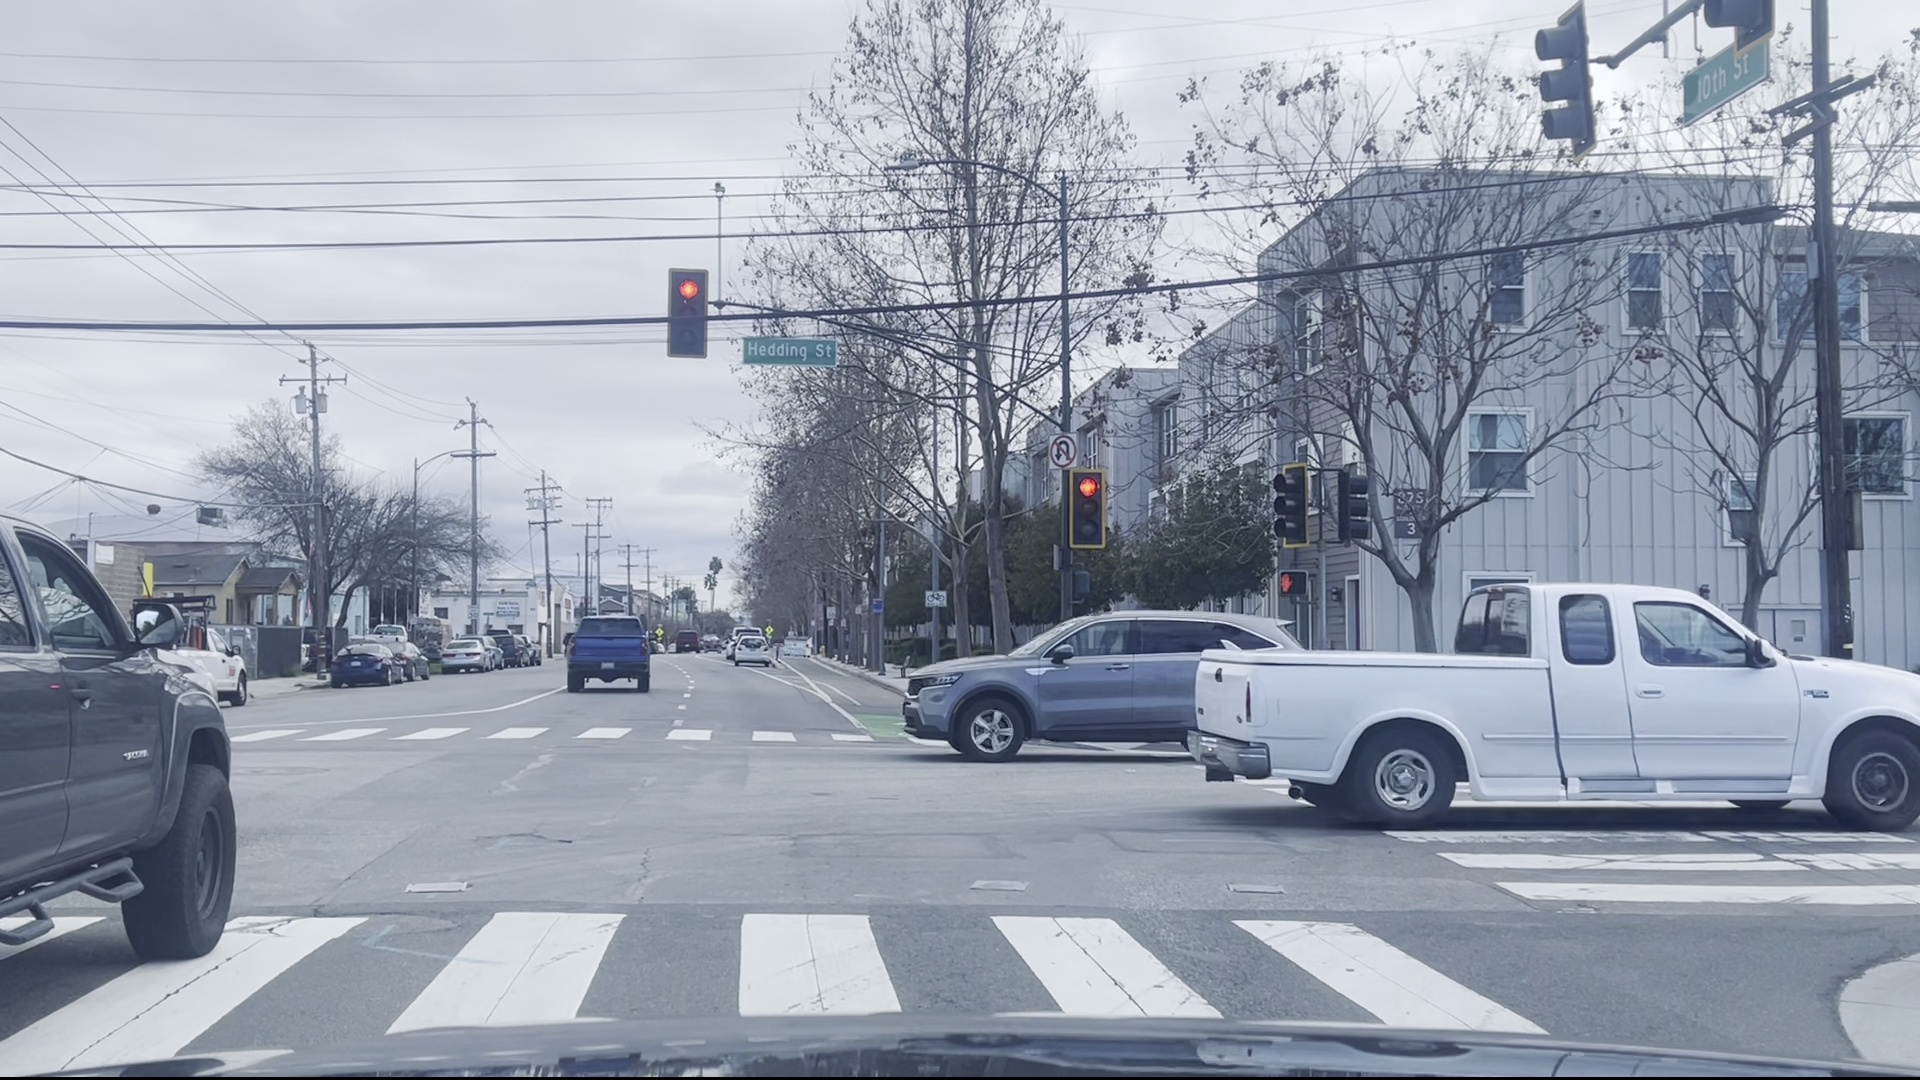

In [5]:
# show the example of image frames
image_example

In [6]:
import os
import torch
import torchvision
from torchvision import transforms
from google.colab.patches import cv2_imshow
from torch.utils.data import DataLoader, random_split
# get the path of all frames

image_dir = '/content/drive/MyDrive/Data255_H4/image_frames'
image_path = []
for root, _, images in os.walk(image_dir):
    for file in images:
        path = os.path.join(root, file)
        image_path.append(path)

In [7]:
# have a look at the path list
image_path[0]

'/content/drive/MyDrive/Data255_H4/image_frames/frame0.jpg'

**Step 2. Conduct inference on each frame of the video, drawing bounding boxes around detected
vehicles.**

In [9]:
#load the pretrain Resnet model
# the model unfreeze the last three backbone layers
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, progress=True, num_classes=91,
                                                             pretrained_backbone=True, trainable_backbone_layers=3,
                                                            min_size=360)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained_backbone' is deprecated since 0.13 and may be removed in the future, please use 'weights_backbone' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weigh

In [10]:
# set the model to inference phase
model.eval()

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(360,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [12]:
#  Faster R-CNN weights is trained from a large dataset COCO, label name in the coco dataset
class_names = ["person" , "bicycle" , "car" , "motorcycle" , "airplane" , "bus" , "train" , "truck" , "boat" , "traffic light" , "fire hydrant" , "street sign" , "stop sign" , "parking meter" , "bench" , "bird" , "cat" , "dog" , "horse" , "sheep" , "cow" , "elephant" , "bear" , "zebra" , "giraffe" , "hat" , "backpack" , "umbrella" , "shoe" , "eye glasses" , "handbag" , "tie" , "suitcase" ,
"frisbee" , "skis" , "snowboard" , "sports ball" , "kite" , "baseball bat" ,
"baseball glove" , "skateboard" , "surfboard" , "tennis racket" , "bottle" ,
"plate" , "wine glass" , "cup" , "fork" , "knife" , "spoon" , "bowl" ,
"banana" , "apple" , "sandwich" , "orange" , "broccoli" , "carrot" , "hot dog" ,
"pizza" , "donut" , "cake" , "chair" , "couch" , "potted plant" , "bed" ,
"mirror" , "dining table" , "window" , "desk" , "toilet" , "door" , "tv" ,
"laptop" , "mouse" , "remote" , "keyboard" , "cell phone" , "microwave" ,
"oven" , "toaster" , "sink" , "refrigerator" , "blender" , "book" ,
"clock" , "vase" , "scissors" , "teddy bear" , "hair drier" , "toothbrush" , "hair brush"]


In [24]:

test_img = Image.open('/content/drive/MyDrive/Data255_H4/image_frames/frame0.jpg')

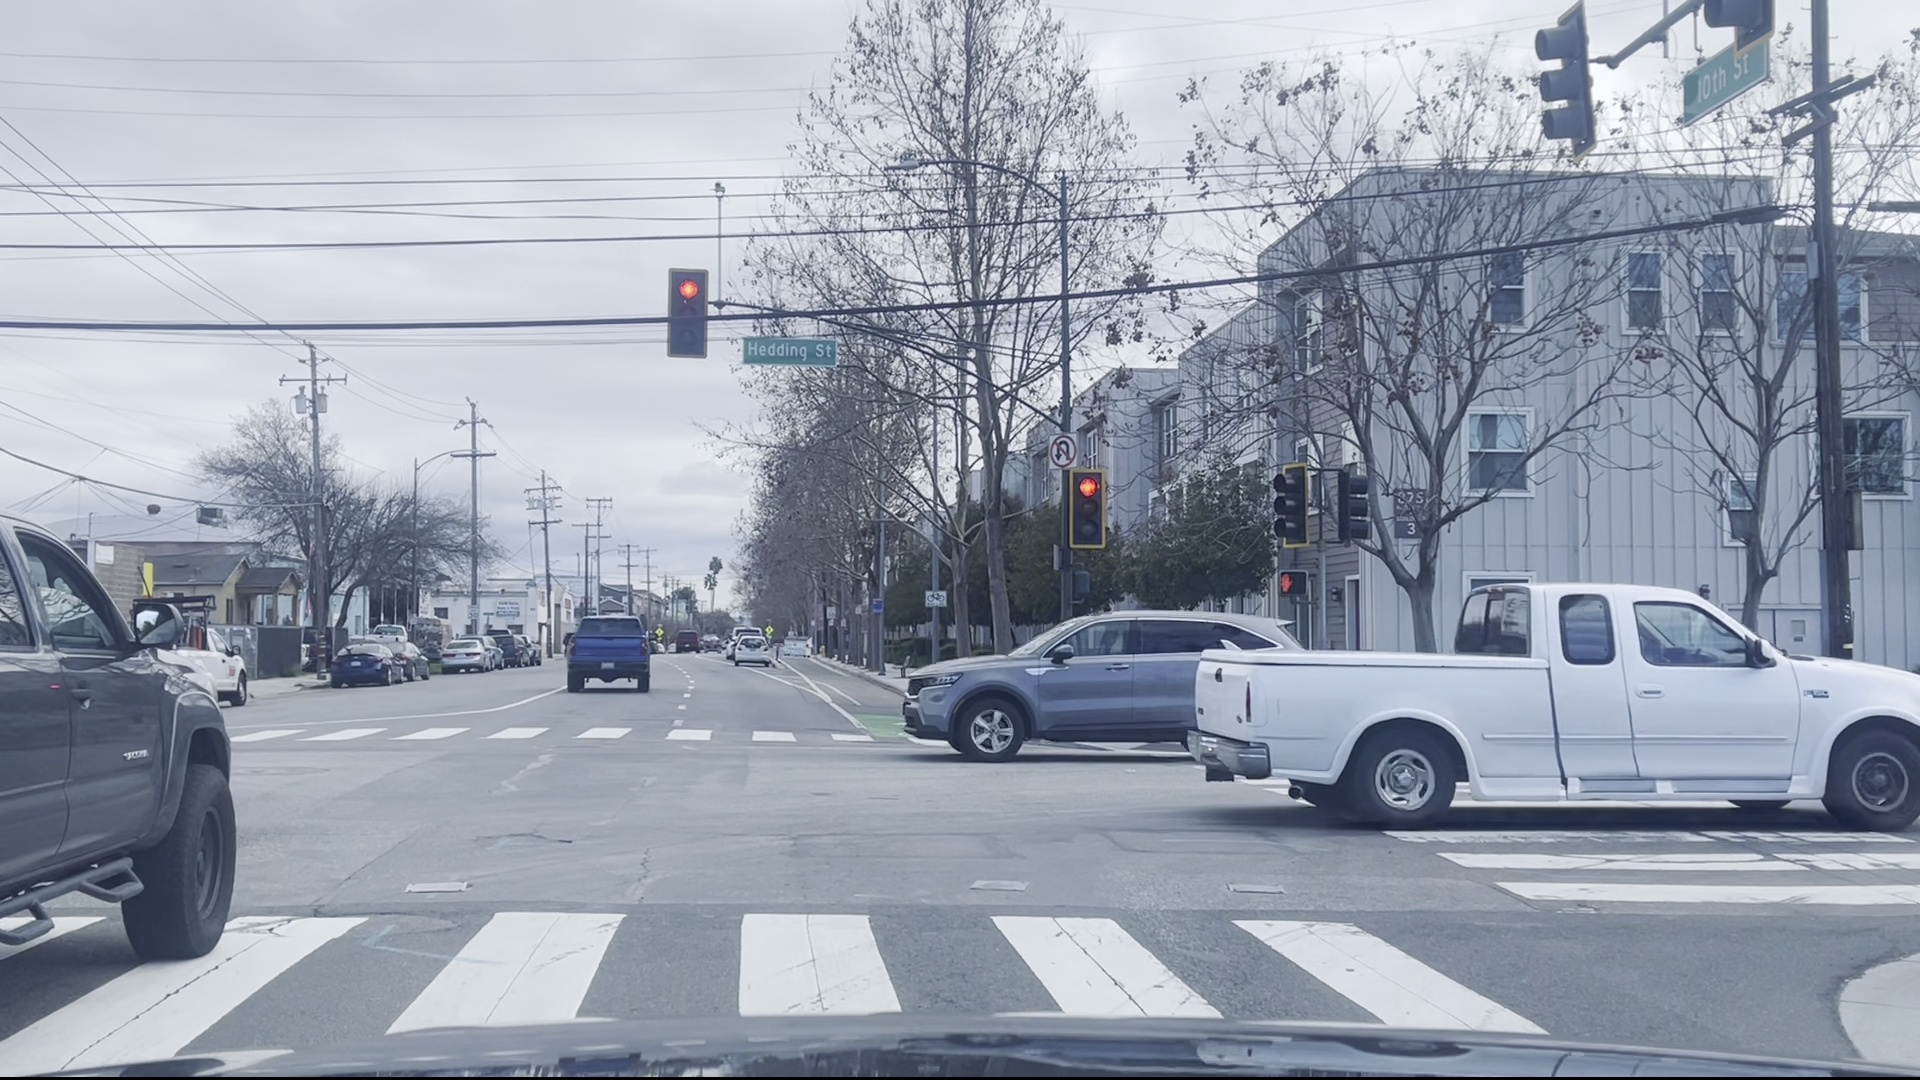

In [25]:
test_img

In [26]:
data_transform = transforms.ToTensor()
test_img = data_transform(test_img)
pred = model([test_img])

In [27]:
# see the output for the model
pred

[{'boxes': tensor([[1.5348e+03, 1.6811e+01, 1.5918e+03, 1.5397e+02],
          [6.6850e+02, 2.7584e+02, 7.0662e+02, 3.5882e+02],
          [9.0162e+02, 6.0913e+02, 1.2837e+03, 7.6320e+02],
          [3.2856e+02, 6.3639e+02, 4.1618e+02, 6.8690e+02],
          [7.2659e+02, 6.2452e+02, 7.7473e+02, 6.6733e+02],
          [4.4529e+02, 6.3634e+02, 4.9343e+02, 6.7425e+02],
          [1.2713e+03, 4.7134e+02, 1.2983e+03, 5.4169e+02],
          [1.5583e+02, 6.3566e+02, 2.4930e+02, 7.0450e+02],
          [1.0723e+03, 4.7655e+02, 1.1027e+03, 5.4404e+02],
          [1.2080e+03, 5.8176e+02, 1.9200e+03, 8.3204e+02],
          [4.9541e+02, 6.2555e+02, 5.3460e+02, 6.6722e+02],
          [6.7100e+02, 6.2446e+02, 7.1924e+02, 6.5575e+02],
          [5.3273e-01, 5.2289e+02, 2.4999e+02, 9.7393e+02],
          [1.2777e+03, 5.7429e+02, 1.2973e+03, 5.9889e+02],
          [5.6538e+02, 6.1406e+02, 6.5446e+02, 6.9150e+02],
          [1.3401e+03, 4.7151e+02, 1.3692e+03, 5.3957e+02],
          [5.1337e+02, 6.2429e+

In [28]:
# we can see the output is a dictionary with boxes, labels and scores as the key
# boxes defines the coordinate of the boxing
# labels represent the predicted object
# the scores show the probability of prediction
pred[0]

{'boxes': tensor([[1.5348e+03, 1.6811e+01, 1.5918e+03, 1.5397e+02],
         [6.6850e+02, 2.7584e+02, 7.0662e+02, 3.5882e+02],
         [9.0162e+02, 6.0913e+02, 1.2837e+03, 7.6320e+02],
         [3.2856e+02, 6.3639e+02, 4.1618e+02, 6.8690e+02],
         [7.2659e+02, 6.2452e+02, 7.7473e+02, 6.6733e+02],
         [4.4529e+02, 6.3634e+02, 4.9343e+02, 6.7425e+02],
         [1.2713e+03, 4.7134e+02, 1.2983e+03, 5.4169e+02],
         [1.5583e+02, 6.3566e+02, 2.4930e+02, 7.0450e+02],
         [1.0723e+03, 4.7655e+02, 1.1027e+03, 5.4404e+02],
         [1.2080e+03, 5.8176e+02, 1.9200e+03, 8.3204e+02],
         [4.9541e+02, 6.2555e+02, 5.3460e+02, 6.6722e+02],
         [6.7100e+02, 6.2446e+02, 7.1924e+02, 6.5575e+02],
         [5.3273e-01, 5.2289e+02, 2.4999e+02, 9.7393e+02],
         [1.2777e+03, 5.7429e+02, 1.2973e+03, 5.9889e+02],
         [5.6538e+02, 6.1406e+02, 6.5446e+02, 6.9150e+02],
         [1.3401e+03, 4.7151e+02, 1.3692e+03, 5.3957e+02],
         [5.1337e+02, 6.2429e+02, 5.4402e+02, 6

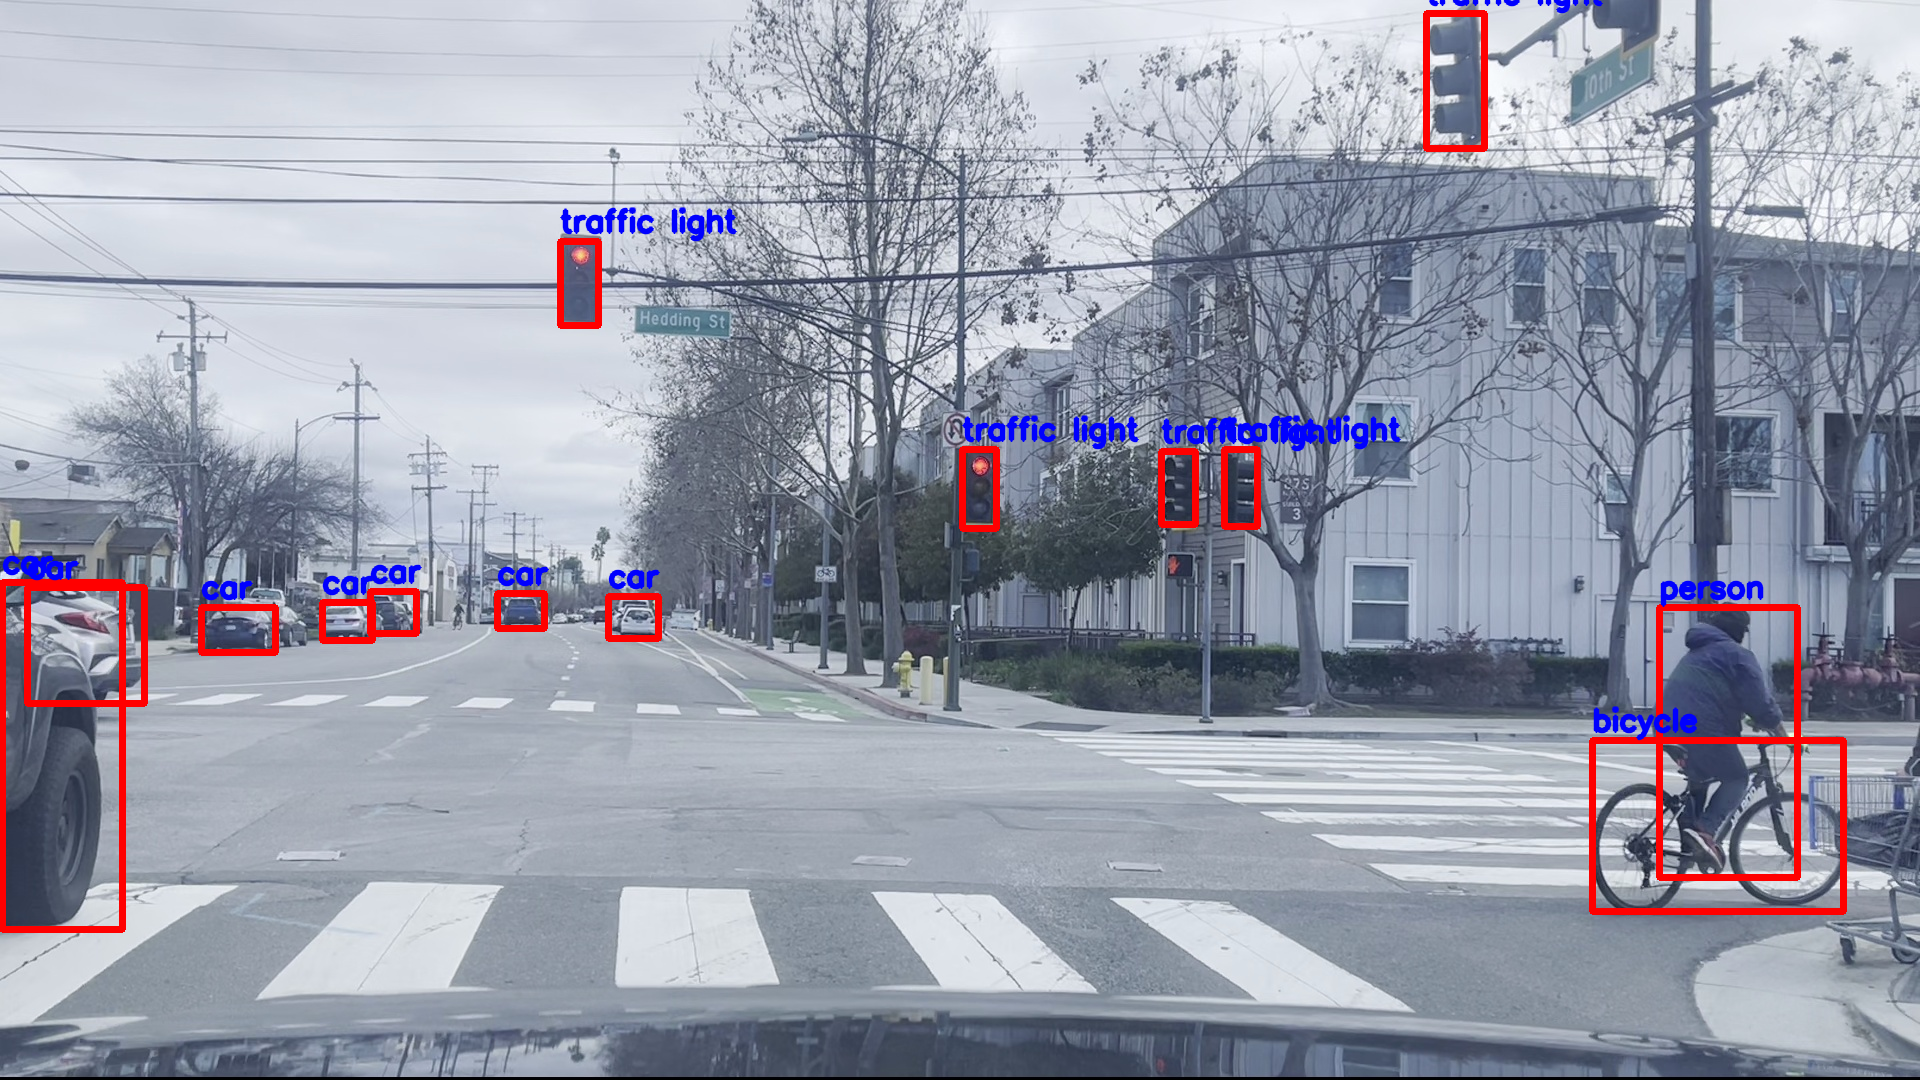

In [ ]:
font = cv2.FONT_HERSHEY_SIMPLEX
# preprocess the frames so they can be fed into a modl

for i in range(len(image_path)):
    im = Image.open(image_path[i])
    img = data_transform(im)
# get the output of the model
    with torch.no_grad():
        pred = model([img])
        # the output of the model is a dictionary with 'boxes', 'labels', 'scores' as keys
        bboxes, labels, scores = pred[0]['boxes'],pred[0]['labels'],pred[0]['scores']
        # the number of the objects we want to detect based on the probability
        num = torch.argwhere( scores > 0.85).shape[0]
        output_dir = '/content/drive/MyDrive/Data255_H4/detect_image/'
        image_to_detect = cv2.imread(image_path[i])
        for n in range(num):
            x1,y1, x2,y2 = bboxes[n].numpy().astype('int')
            # class_name is a list which contains all the class labels, index starting from 0
            cls_name = class_names[labels.numpy()[n]-1]
            # drawing the boxings around the objects, setting the color and thickness
            image_to_detect = cv2.rectangle(image_to_detect,(x1,y1),(x2,y2),(0,0,255),5)
            # put the text on the top of the boxing, setting the font, size, color and thickness
            image_to_detect = cv2.putText(image_to_detect, cls_name, (x1,y1-10),font,1,(255,0,0),3, cv2.LINE_AA)
    # change to the dir to which we want to save the detected images
    os.chdir(output_dir)
    # saving the images
    cv2.imwrite(f'frame{i}.jpg', image_to_detect)
cv2_imshow(image_to_detect)

**Step 3. Format the results back into a video.**

In [ ]:
# Specify the folder containing the images and the output video file path
frame_dir = '/content/drive/MyDrive/Data255_H4/detected_image/'
output_video_path = '/content/drive/MyDrive/Data255_H4'

import numpy as np
import glob
# get the collection of the path of the frames
output_fram_path = []
for root, _, files in os.walk(frame_dir):
    for file in files:
        path = os.path.join(root, file)
        output_fram_path.append(path)

In [ ]:
# get the size of image
output_img = cv2.imread('/content/drive/MyDrive/Data255_H4/detected_image/frame90.jpg')
height, width, layers = output_img.shape
size = (width, height)
# change the dir to target output video path
os.chdir(output_video_path)
out = cv2.VideoWriter('video.mov',cv2.VideoWriter_fourcc(*'MJPG'), 15, size)
# convert the frames back to the videos
for i in range(len(output_fram_path)):
    img = cv2.imread(output_fram_path[i])
    out.write(img)
out.release()